---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# <center>영구 자석 동기 모터(PMSM) 부품 온도 예측</center>

컬럼 | 설명 | 컬럼 | 설명
---|---|---|---
id | 고유번호 | motor_speed | 모터 회전속도
ambient | 주변 온도 | coolant | 냉각수 온도
u_q | 전압 q | u_d | 전압 d
i_d | 전류 q | i_q | 전류 d
pm | 특정 부품(rotor) 온도 | 

![pmsm](https://ko.tech-zy.com/js/htmledit/kindeditor/attached/20210420/20210420170944_90438.jpg)

# Library

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# 데이터셋 업로드

In [ ]:
# 구글 드라이브 연결하기
# from google.colab import drive
# drive.mount('./MyDrive')

In [ ]:
# 구글 드라이브 연결하기
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


# Load Dataset

In [ ]:
train = pd.read_csv("/content/MyDrive/MyDrive/motor_temperature-20211118T021215Z-001/motor_temperature/train.csv")
train.head()

,id,ambient,coolant,motor_speed,u_q,u_d,i_d,i_q,pm
0,0,26.351160,64.363928,2922.485778,128.225872,-29.600023,-16.722047,28.266956,66.688690
1,1,26.018845,80.605671,1913.623302,70.050099,75.969371,-37.767195,-127.116627,64.558285
2,2,26.233084,85.366168,0.004871,0.343952,-0.807201,-2.000640,1.097852,81.379509
3,3,25.859851,81.489642,2585.293386,111.671886,51.157701,-10.948034,-56.338080,62.454746
4,4,20.505171,18.593714,1449.987549,56.055401,-77.052261,-65.980156,172.999969,35.819004


In [ ]:
test = pd.read_csv("/content/MyDrive/MyDrive/motor_temperature-20211118T021215Z-001/motor_temperature/test.csv")
test.head()

,id,ambient,coolant,motor_speed,u_q,u_d,i_d,i_q
0,200000,26.382779,67.761581,2128.084041,95.097209,-8.055686,-6.071860,9.718223
1,200001,26.197638,88.113488,3255.284819,7.437008,-130.246107,-221.003540,128.155708
2,200002,27.609122,54.652056,1049.563359,31.263312,51.597308,-57.866079,-164.880333
3,200003,26.383675,46.428369,-0.011951,0.448320,2.626701,-2.000621,1.097699
4,200004,26.384509,35.798158,0.004380,0.475550,2.711885,-2.000394,1.097061


In [ ]:
submission = pd.read_csv("/content/MyDrive/MyDrive/motor_temperature-20211118T021215Z-001/motor_temperature/sample_submission.csv")
submission.head()

,id,pm
0,200000,0.0
1,200001,0.0
2,200002,0.0
3,200003,0.0
4,200004,0.0


# 데이터 탐색 (EDA)

### 데이터프레임 크기(세로, 가로)

In [ ]:
train.shape

(200000, 9)

In [ ]:
test.shape

(20000, 8)

### 데이터프레임 기본 정보

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           200000 non-null  int64  
 1   ambient      200000 non-null  float64
 2   coolant      200000 non-null  float64
 3   motor_speed  200000 non-null  float64
 4   u_q          200000 non-null  float64
 5   u_d          200000 non-null  float64
 6   i_d          200000 non-null  float64
 7   i_q          200000 non-null  float64
 8   pm           200000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 13.7 MB


### 통계정보 요약

In [ ]:
train.describe()

,id,ambient,coolant,motor_speed,u_q,u_d,i_d,i_q,pm
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,99999.500000,24.508792,35.768202,2220.866633,54.769451,-26.741614,-69.480501,39.483355,58.349590
std,57735.171256,1.942757,21.778163,1854.554926,44.058583,62.747767,65.107320,92.102039,19.147345
min,0.000000,14.100689,14.168249,-249.252652,-25.290930,-131.430511,-278.003632,-293.409766,21.047161
25%,49999.750000,23.174347,18.680056,432.595665,12.125014,-82.125127,-116.178437,1.096007,42.742199
50%,99999.500000,24.757979,24.637102,1999.977539,49.155929,-7.613223,-52.706244,21.216663,60.208411
75%,149999.250000,26.152535,49.824245,3779.967285,90.204736,1.331288,-2.980488,105.246002,71.918205
max,199999.000000,30.443151,93.747816,6000.015137,133.020315,131.410355,0.026684,301.707489,113.589684


In [ ]:
train.sum()

id             1.999990e+10
ambient        4.901758e+06
coolant        7.153640e+06
motor_speed    4.441733e+08
u_q            1.095389e+07
u_d           -5.348323e+06
i_d           -1.389610e+07
i_q            7.896671e+06
pm             1.166992e+07
dtype: float64

### 중복행 개수

In [ ]:
train.isnull()

,id,ambient,coolant,motor_speed,u_q,u_d,i_d,i_q,pm
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
199995,False,False,False,False,False,False,False,False,False
199996,False,False,False,False,False,False,False,False,False
199997,False,False,False,False,False,False,False,False,False
199998,False,False,False,False,False,False,False,False,False


In [ ]:
train.duplicated().sum()

0

In [ ]:
test.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
19995    False
19996    False
19997    False
19998    False
19999    False
Length: 20000, dtype: bool

In [ ]:
test.duplicated().sum()

0

### 결측치 개수

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

## Target 목표 변수 (전기 모터 부품의 온도: pm)

In [ ]:
train["pm"].describe()

count    200000.000000
mean         58.349590
std          19.147345
min          21.047161
25%          42.742199
50%          60.208411
75%          71.918205
max         113.589684
Name: pm, dtype: float64

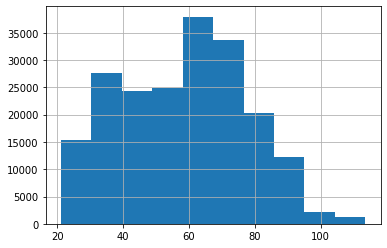

In [ ]:
train["pm"].hist()

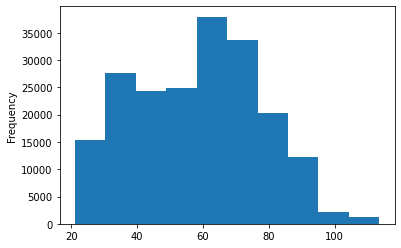

In [ ]:
train["pm"].plot(kind='hist')

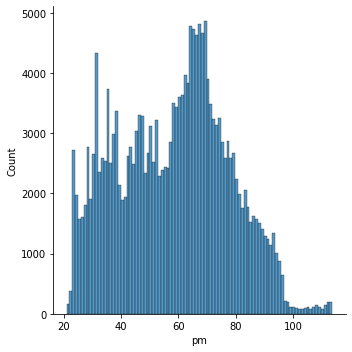

In [ ]:
sns.displot(x='pm', data=train);

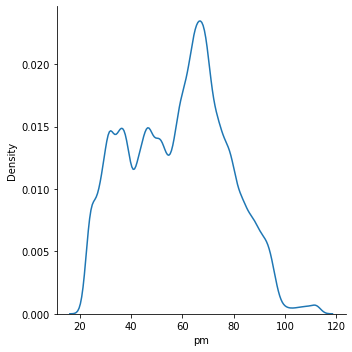

In [ ]:
sns.displot(x='pm', kind='kde', data=train);

## Pairplot 데이터 분포

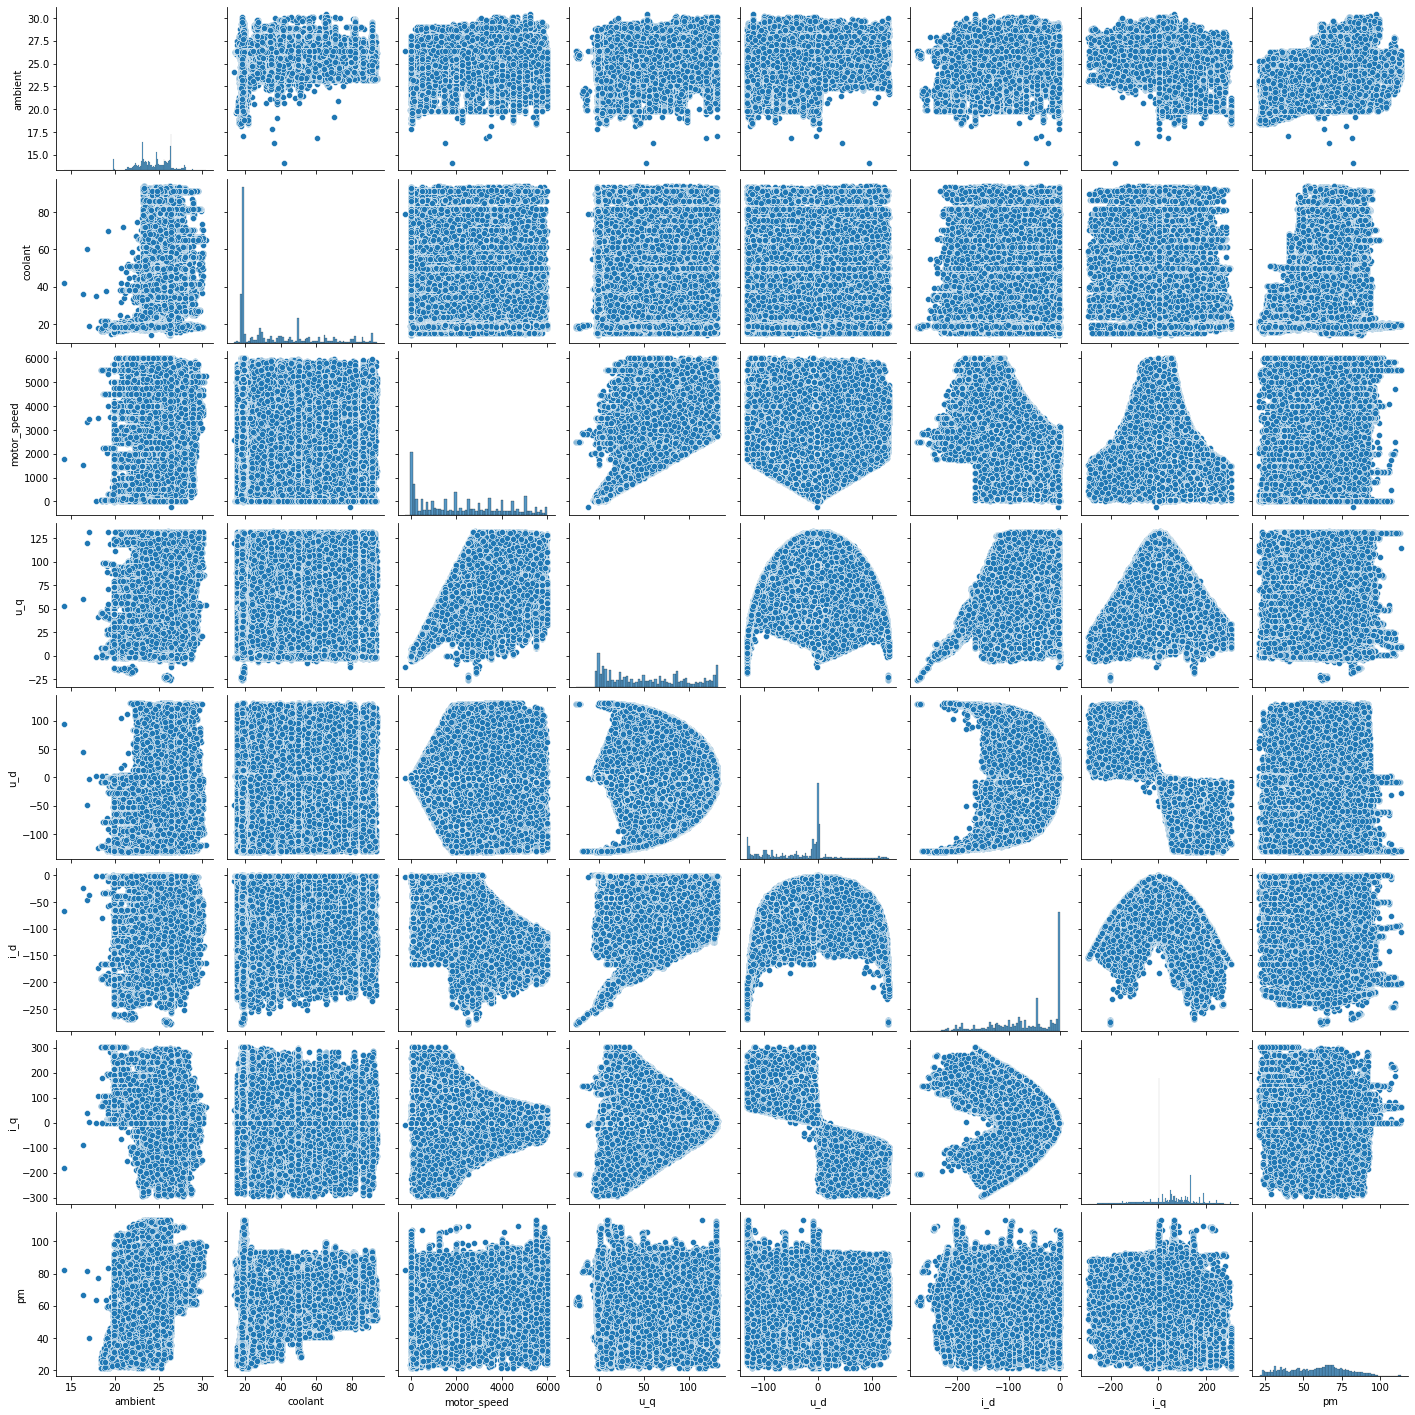

In [ ]:
sns.pairplot(data=train.iloc[:, 1:], diag_kind='hist');

## 상관계수 분석

In [ ]:
train.iloc[ :  , 1:]. corr()

,ambient,coolant,motor_speed,u_q,u_d,i_d,i_q,pm
ambient,1.000000,0.531525,0.124162,0.165960,0.189794,0.019155,-0.303472,0.512778
coolant,0.531525,1.000000,0.010426,0.055485,0.198207,0.079790,-0.259711,0.464285
motor_speed,0.124162,0.010426,1.000000,0.676134,-0.303732,-0.694610,-0.071400,0.464435
u_q,0.165960,0.055485,0.676134,1.000000,0.008431,-0.082344,-0.133942,0.120627
u_d,0.189794,0.198207,-0.303732,0.008431,1.000000,0.469390,-0.715814,-0.190925
i_d,0.019155,0.079790,-0.694610,-0.082344,0.469390,1.000000,-0.241579,-0.430561
i_q,-0.303472,-0.259711,-0.071400,-0.133942,-0.715814,-0.241579,1.000000,-0.132163
pm,0.512778,0.464285,0.464435,0.120627,-0.190925,-0.430561,-0.132163,1.000000


In [ ]:
# 상관계수 테이블
df_corr = train.iloc[:, 1:].corr()
df_corr

,ambient,coolant,motor_speed,u_q,u_d,i_d,i_q,pm
ambient,1.000000,0.531525,0.124162,0.165960,0.189794,0.019155,-0.303472,0.512778
coolant,0.531525,1.000000,0.010426,0.055485,0.198207,0.079790,-0.259711,0.464285
motor_speed,0.124162,0.010426,1.000000,0.676134,-0.303732,-0.694610,-0.071400,0.464435
u_q,0.165960,0.055485,0.676134,1.000000,0.008431,-0.082344,-0.133942,0.120627
u_d,0.189794,0.198207,-0.303732,0.008431,1.000000,0.469390,-0.715814,-0.190925
i_d,0.019155,0.079790,-0.694610,-0.082344,0.469390,1.000000,-0.241579,-0.430561
i_q,-0.303472,-0.259711,-0.071400,-0.133942,-0.715814,-0.241579,1.000000,-0.132163
pm,0.512778,0.464285,0.464435,0.120627,-0.190925,-0.430561,-0.132163,1.000000


In [ ]:
# Target 변수와 상관계수가 높은 순서대로 정렬
df_corr.loc[ :  ,  ['pm']  ].abs().sort_values(by=['pm'], ascending=False)

,pm
pm,1.000000
ambient,0.512778
motor_speed,0.464435
coolant,0.464285
i_d,0.430561
u_d,0.190925
i_q,0.132163
u_q,0.120627


In [ ]:
# 강제 한글  포트 설치 방법 구글링  https://teddylee777.github.io/colab/colab-korean
# 참고링크 https://datascienceschool.net/01%20python/05.04%20%EC%8B%9C%EB%B3%B8%EC%9D%84%20%EC%82%AC%EC%9A%A9%ED%95%9C%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%ED%8F%AC%20%EC%8B%9C%EA%B0%81%ED%99%94.html
# 그래프링크 http://seaborn.pydata.org/examples/index.html


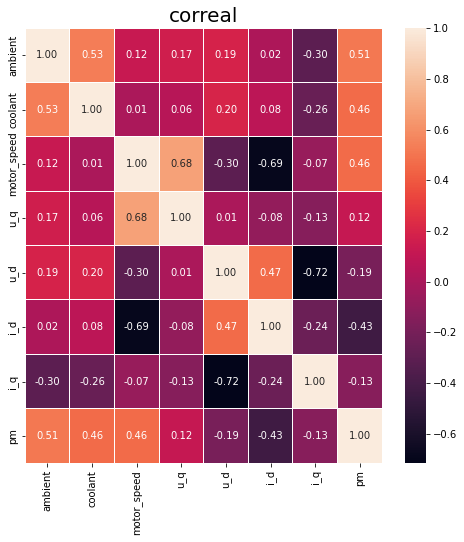

In [ ]:
# 히트맵
plt.figure(figsize=(8, 8))

sns.heatmap(data=df_corr, annot=True, cbar=True,
           linewidths=0.05, linecolor="white", fmt= '.2f')
plt.title('correal'   ,   fontsize=20)

plt.show()

## 데이터 분포

In [ ]:
train.columns[ : ]

Index(['id', 'ambient', 'coolant', 'motor_speed', 'u_q', 'u_d', 'i_d', 'i_q',
       'pm'],
      dtype='object')

In [ ]:
for c in train.columns[1:]:
   print(c)

ambient
coolant
motor_speed
u_q
u_d
i_d
i_q
pm


In [ ]:
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False


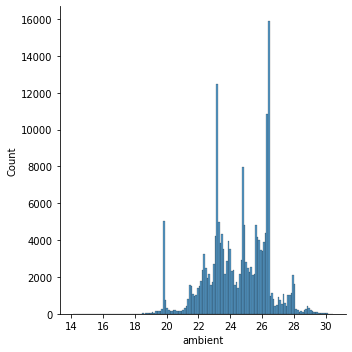

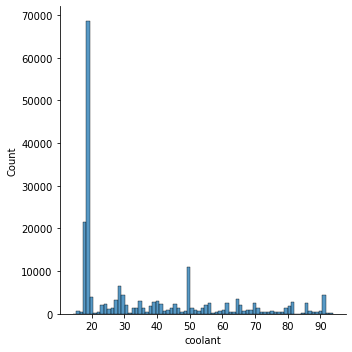

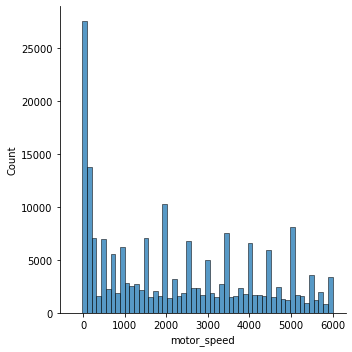

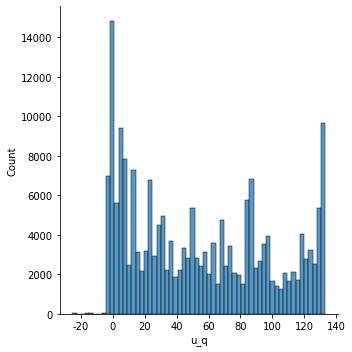

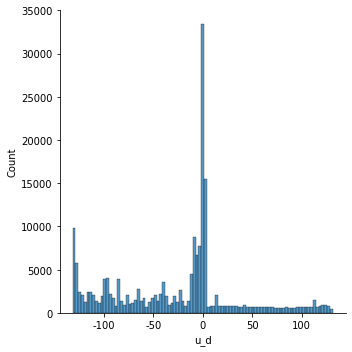

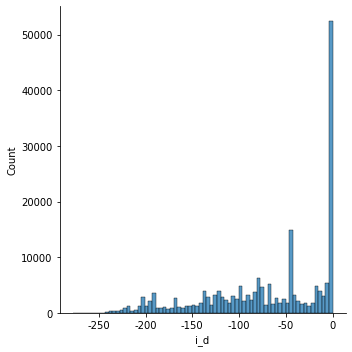

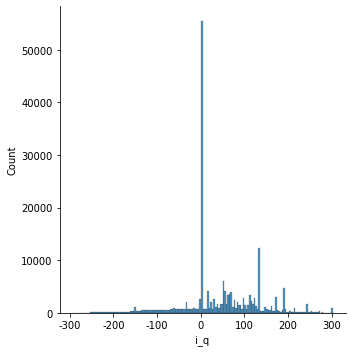

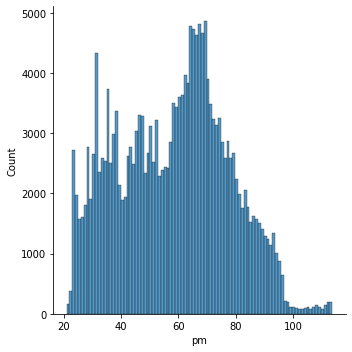

In [ ]:
for col in train.columns[1:]:
    sns.displot(x=col, data =train)

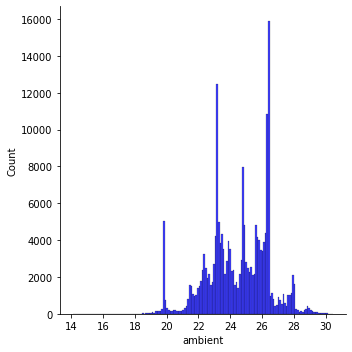

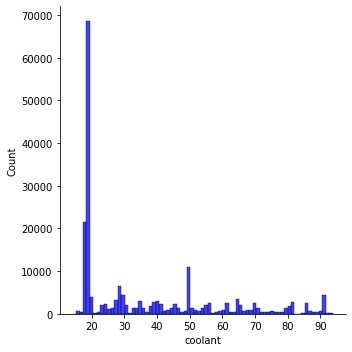

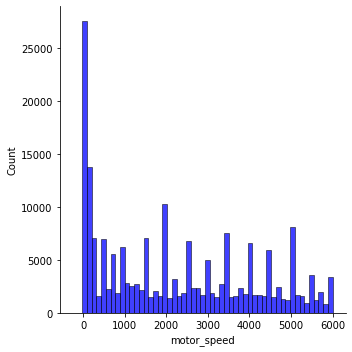

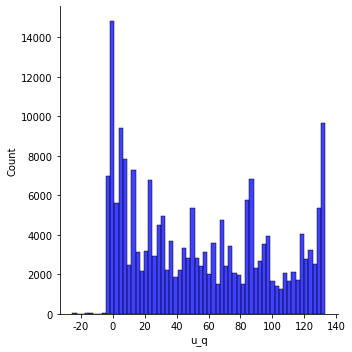

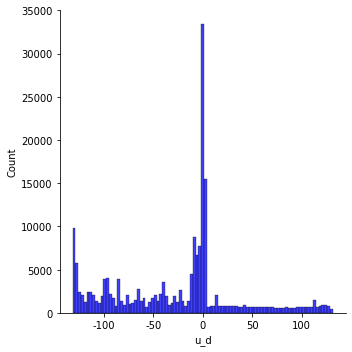

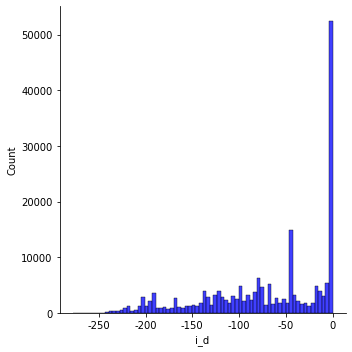

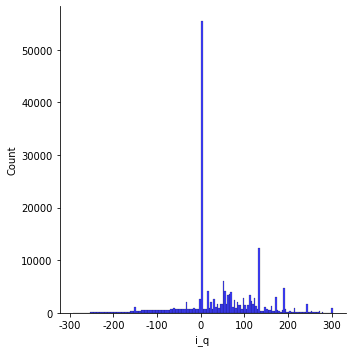

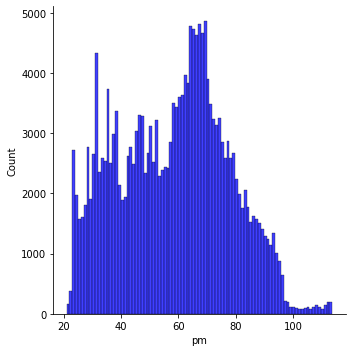

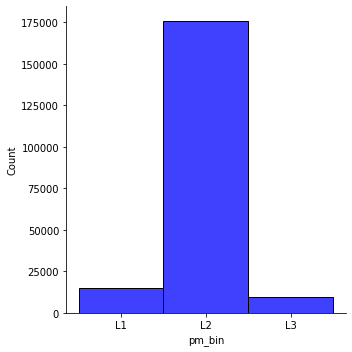

In [ ]:
for col in train.columns[1:]:
    sns.displot(train[col], color ='b')
    plt.show()

## Target 구간을 나누고, 구간에 따른 변수 차이 확인

In [ ]:
bins = [0, 30, 90, 120]

In [ ]:
bin_labels = ['L1', 'L2', 'L3']

In [ ]:
pd.cut(train['pm'], bins=bins, labels=bin_labels)

0         L2
1         L2
2         L2
3         L2
4         L2
          ..
199995    L2
199996    L2
199997    L2
199998    L2
199999    L3
Name: pm, Length: 200000, dtype: category
Categories (3, object): ['L1' < 'L2' < 'L3']

In [ ]:
train['pm_bin'] = pd.cut(train['pm'], bins=bins, labels=bin_labels)
train['pm_bin'].value_counts()

L2    175715
L1     14920
L3      9365
Name: pm_bin, dtype: int64

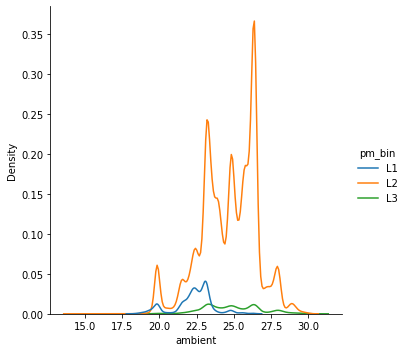

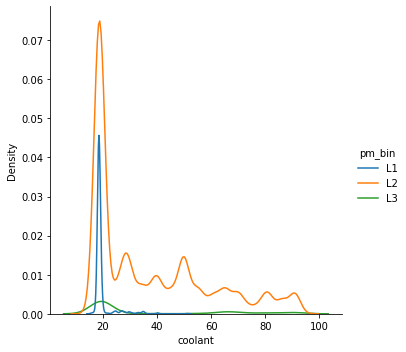

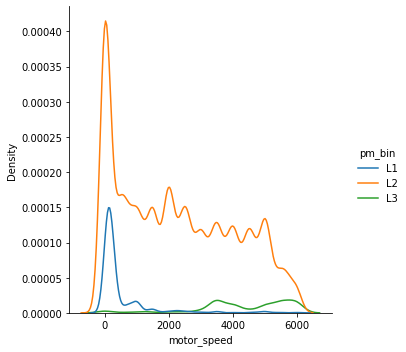

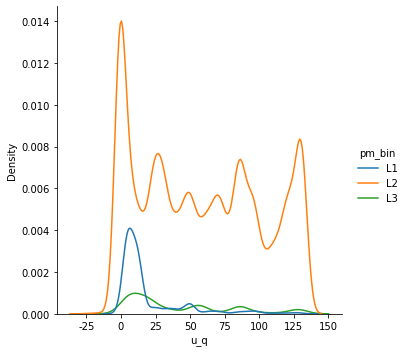

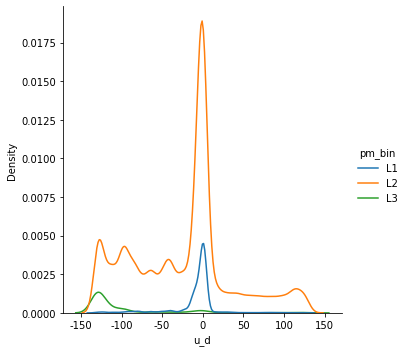

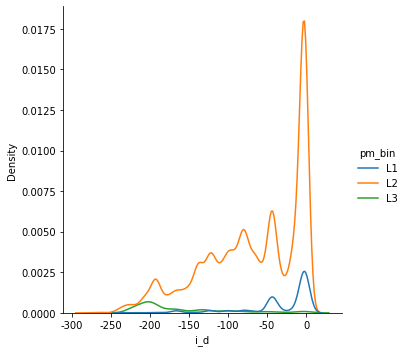

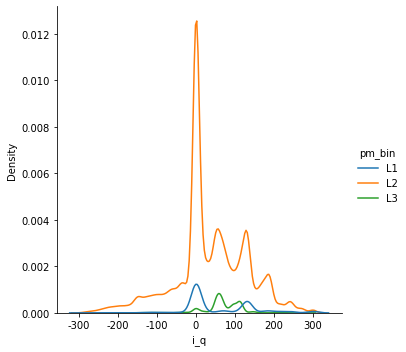

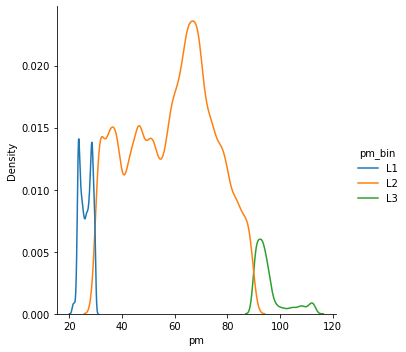

In [ ]:
for col in train.columns[1:-1]:
    sns.displot(x=col, hue='pm_bin', kind='kde', data=train, color ='b')
    plt.show()

# Regression 알고리즘

## 단순회귀분석

In [ ]:
train

,id,ambient,coolant,motor_speed,u_q,u_d,i_d,i_q,pm,pm_bin
0,0,26.351160,64.363928,2922.485778,128.225872,-29.600023,-16.722047,28.266956,66.688690,L2
1,1,26.018845,80.605671,1913.623302,70.050099,75.969371,-37.767195,-127.116627,64.558285,L2
2,2,26.233084,85.366168,0.004871,0.343952,-0.807201,-2.000640,1.097852,81.379509,L2
3,3,25.859851,81.489642,2585.293386,111.671886,51.157701,-10.948034,-56.338080,62.454746,L2
4,4,20.505171,18.593714,1449.987549,56.055401,-77.052261,-65.980156,172.999969,35.819004,L2
...,...,...,...,...,...,...,...,...,...,...
199995,199995,26.384507,86.143200,1480.493011,68.091347,-12.005407,-6.311725,22.917076,64.428006,L2
199996,199996,24.970987,18.652084,4499.954102,124.023514,-43.731369,-88.664307,24.634653,71.212433,L2
199997,199997,24.464699,59.238445,0.002326,-0.368311,-0.754298,-2.000976,1.097733,71.035578,L2
199998,199998,24.847108,38.911599,1082.760740,28.884056,61.782013,-82.756359,-205.411509,35.622897,L2


In [ ]:
train.columns

Index(['id', 'ambient', 'coolant', 'motor_speed', 'u_q', 'u_d', 'i_d', 'i_q',
       'pm', 'pm_bin'],
      dtype='object')

In [ ]:
# 선형회귀분석할때 머신러닝할때 쓰는 싸이키런  sklearn  ,    
from sklearn.linear_model import LinearRegression

In [ ]:
lr_model = LinearRegression()

In [ ]:
# X, y 변수 정리

X_train = train.loc[ : , [ 'ambient', 'coolant' , 'i_d' ] ]
y_train = train['pm']

print(X_train.shape, y_train.shape)

(200000, 3) (200000,)


In [ ]:
# 모델 훈련
lr_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
lr_model.coef_

array([ 3.50624508,  0.27437732, -0.13595008])

In [ ]:
lr_model.intercept_

-46.84410592498265

In [ ]:
# y= 5x - 65

In [ ]:
# 모델 예측
y_pred = lr_model.predict(X_train)

In [ ]:
y_pred

array([65.48288653, 71.63516443, 68.83004503, ..., 55.46084294,
       62.20313999, 56.70645324])

In [ ]:
# 평가 지표 - mean_squared_error
from sklearn.metrics import mean_squared_error
print("평균제곱오차: %0.2f" % mean_squared_error(y_train, y_pred))

평균제곱오차: 173.65


In [ ]:
submission.to_csv('prediction_020.csv', index=False)

## 모델 예측

In [ ]:
test

,id,ambient,coolant,motor_speed,u_q,u_d,i_d,i_q
0,200000,26.382779,67.761581,2128.084041,95.097209,-8.055686,-6.071860,9.718223
1,200001,26.197638,88.113488,3255.284819,7.437008,-130.246107,-221.003540,128.155708
2,200002,27.609122,54.652056,1049.563359,31.263312,51.597308,-57.866079,-164.880333
3,200003,26.383675,46.428369,-0.011951,0.448320,2.626701,-2.000621,1.097699
4,200004,26.384509,35.798158,0.004380,0.475550,2.711885,-2.000394,1.097061
...,...,...,...,...,...,...,...,...
19995,219995,26.384177,56.105289,1445.806822,59.929095,33.444934,-13.975891,-66.555724
19996,219996,26.384507,35.798158,0.005345,0.570451,2.743213,-2.000802,1.097050
19997,219997,24.904948,75.734681,4279.620561,110.683360,-59.994503,-96.242880,38.496422
19998,219998,26.384398,56.113731,1485.996191,60.395461,-63.097747,-41.888559,128.759342


In [ ]:
# 변수 선택
X_test = test.loc[:, ['ambient']]
# 예측
preds = lr_model.predict(X_test)

ValueError: ignored

In [ ]:
len(preds)

20000

## Submission 파일 만들기

In [ ]:
submission.head()

,id,pm
0,200000,0.0
1,200001,0.0
2,200002,0.0
3,200003,0.0
4,200004,0.0


In [ ]:
submission['pm'] = preds
submission

,id,pm
0,200000,67.820365
1,200001,66.884700
2,200002,74.018075
3,200003,67.824898
4,200004,67.829111
...,...,...
19995,219995,67.827433
19996,219996,67.829103
19997,219997,60.351685
19998,219998,67.828552


In [ ]:
submission.to_csv('prediction_001.csv', index=False)

In [ ]:
# 저장 파일을 평가 시스템에 제출
# https://newlearn.kr/login   로그인 사내 메일 주소 / 비번은 dbgroup1234



## 다중회귀분석

In [ ]:
train

,id,ambient,coolant,motor_speed,u_q,u_d,i_d,i_q,pm,pm_bin
0,0,26.351160,64.363928,2922.485778,128.225872,-29.600023,-16.722047,28.266956,66.688690,L2
1,1,26.018845,80.605671,1913.623302,70.050099,75.969371,-37.767195,-127.116627,64.558285,L2
2,2,26.233084,85.366168,0.004871,0.343952,-0.807201,-2.000640,1.097852,81.379509,L2
3,3,25.859851,81.489642,2585.293386,111.671886,51.157701,-10.948034,-56.338080,62.454746,L2
4,4,20.505171,18.593714,1449.987549,56.055401,-77.052261,-65.980156,172.999969,35.819004,L2
...,...,...,...,...,...,...,...,...,...,...
199995,199995,26.384507,86.143200,1480.493011,68.091347,-12.005407,-6.311725,22.917076,64.428006,L2
199996,199996,24.970987,18.652084,4499.954102,124.023514,-43.731369,-88.664307,24.634653,71.212433,L2
199997,199997,24.464699,59.238445,0.002326,-0.368311,-0.754298,-2.000976,1.097733,71.035578,L2
199998,199998,24.847108,38.911599,1082.760740,28.884056,61.782013,-82.756359,-205.411509,35.622897,L2


In [ ]:
X_train

,ambient,coolant,motor_speed
0,26.351160,64.363928,2922.485778
1,26.018845,80.605671,1913.623302
2,26.233084,85.366168,0.004871
3,25.859851,81.489642,2585.293386
4,20.505171,18.593714,1449.987549
...,...,...,...
199995,26.384507,86.143200,1480.493011
199996,24.970987,18.652084,4499.954102
199997,24.464699,59.238445,0.002326
199998,24.847108,38.911599,1082.760740


In [ ]:
# X, y 변수 정리

X_train = train.loc[:, ['ambient', 'coolant' , 'motor_speed']]
y_train = train['pm']

X_test = test.loc[:, ['ambient', 'coolant']]

print(X_train.shape, y_train.shape, X_test.shape)

(200000, 3) (200000,) (20000, 2)


In [ ]:
lr_model = LinearRegression()

In [ ]:
# 모델 훈련
lr_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
lr_model.coef_

array([2.9630718 , 0.26381687, 0.00437736])

In [ ]:
lr_model.intercept_

-33.429517873755266

In [ ]:
# 모델 예측
y_pred = lr_model.predict(X_train)

In [ ]:
# 평가 지표 - mean_squared_error
from sklearn.metrics import mean_squared_error
print("평균제곱오차: %0.2f" % mean_squared_error(y_train, y_pred))

평균제곱오차: 186.83


# 피처 스케일링

In [ ]:
X_train

,ambient,coolant,motor_speed
0,26.351160,64.363928,2922.485778
1,26.018845,80.605671,1913.623302
2,26.233084,85.366168,0.004871
3,25.859851,81.489642,2585.293386
4,20.505171,18.593714,1449.987549
...,...,...,...
199995,26.384507,86.143200,1480.493011
199996,24.970987,18.652084,4499.954102
199997,24.464699,59.238445,0.002326
199998,24.847108,38.911599,1082.760740


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 스케일링 모델 생성
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = X_train.copy()
X_train_scaled.loc[:, :] = scaler.transform(X_train)

In [ ]:
X_train_scaled

,ambient,coolant,motor_speed
0,0.749610,0.630761,0.507538
1,0.729275,0.834855,0.346101
2,0.742385,0.894676,0.039886
3,0.719547,0.845963,0.453581
4,0.391892,0.055611,0.271910
...,...,...,...
199995,0.751650,0.904440,0.276792
199996,0.665157,0.056344,0.759962
199997,0.634177,0.566354,0.039885
199998,0.657577,0.310926,0.213147


In [ ]:
# 스케일러 모델 훈련
scaler.fit(X_train)

MinMaxScaler()

In [ ]:
X_train.copy()

,ambient,coolant,motor_speed
0,26.351160,64.363928,2922.485778
1,26.018845,80.605671,1913.623302
2,26.233084,85.366168,0.004871
3,25.859851,81.489642,2585.293386
4,20.505171,18.593714,1449.987549
...,...,...,...
199995,26.384507,86.143200,1480.493011
199996,24.970987,18.652084,4499.954102
199997,24.464699,59.238445,0.002326
199998,24.847108,38.911599,1082.760740


In [ ]:
scaler.transform(X_train)

array([[0.74960988, 0.63076089, 0.50753761],
       [0.72927543, 0.83485528, 0.3461007 ],
       [0.74238478, 0.89467587, 0.03988588],
       ...,
       [0.63417675, 0.56635387, 0.03988547],
       [0.65757651, 0.31092592, 0.21314711],
       [0.61250896, 0.06811578, 0.91998023]])

In [ ]:
# 스케일링 변환
X_train_scaled = X_train.copy()
X_train_scaled.loc[:, :] = scaler.transform(X_train)

X_train_scaled.describe()

,ambient,coolant,motor_speed
count,200000.000000,200000.000000,200000.000000
mean,0.636875,0.271426,0.395265
std,0.118878,0.273665,0.296764
min,0.000000,0.000000,0.000000
25%,0.555220,0.056696,0.109109
50%,0.652123,0.131552,0.359919
75%,0.737456,0.448055,0.644751
max,1.000000,1.000000,1.000000


In [ ]:
# 스케일링 변환
X_test_scaled = X_test.copy()
X_test_scaled.loc[:, :] = scaler.transform(X_test)

X_test_scaled.describe()

ValueError: ignored

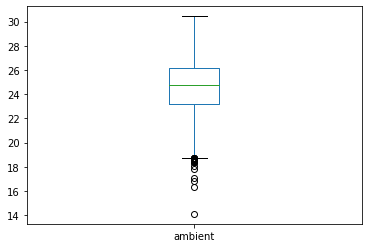

In [ ]:
X_train['ambient'].plot(kind='box')

In [ ]:
X_train['ambient'] >= 20

0         True
1         True
2         True
3         True
4         True
          ... 
199995    True
199996    True
199997    True
199998    True
199999    True
Name: ambient, Length: 200000, dtype: bool

In [ ]:
X_train.loc[X_train['ambient'] >= 20,    : ]

,id,ambient,coolant,motor_speed,u_q,u_d,i_d,i_q
0,0,26.351160,64.363928,2922.485778,128.225872,-29.600023,-16.722047,28.266956
1,1,26.018845,80.605671,1913.623302,70.050099,75.969371,-37.767195,-127.116627
2,2,26.233084,85.366168,0.004871,0.343952,-0.807201,-2.000640,1.097852
3,3,25.859851,81.489642,2585.293386,111.671886,51.157701,-10.948034,-56.338080
4,4,20.505171,18.593714,1449.987549,56.055401,-77.052261,-65.980156,172.999969
...,...,...,...,...,...,...,...,...
199995,199995,26.384507,86.143200,1480.493011,68.091347,-12.005407,-6.311725,22.917076
199996,199996,24.970987,18.652084,4499.954102,124.023514,-43.731369,-88.664307,24.634653
199997,199997,24.464699,59.238445,0.002326,-0.368311,-0.754298,-2.000976,1.097733
199998,199998,24.847108,38.911599,1082.760740,28.884056,61.782013,-82.756359,-205.411509


In [ ]:
X_train1 = X_train.loc[X_train['ambient'] >= 20,    : ]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train1)
X_train1_scaled = X_train1.copy()
X_train1_scaled.loc[:, :] = scaler.transform(X_train)

ValueError: ignored

# 홀드아웃 교차 검증

## Train - Test 분할

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train, test_size=0.3, random_state=2021)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(140000, 3) (140000,)
(60000, 3) (60000,)


## 과대 적합 (over-fitting)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# 1차 다항식으로 변환
polynomial = PolynomialFeatures(degree=1)  

X_tr_poly=polynomial.fit_transform(X_tr)   
X_val_poly=polynomial.fit_transform(X_val)  

print(X_tr_poly.shape, X_val_poly.shape)

In [ ]:
pr_model = LinearRegression()
pr_model.fit(X_tr_poly, y_tr)

In [ ]:
from sklearn.metrics import mean_squared_error

y_tr_pred = pr_model.predict(X_tr_poly)
train_mse = mean_squared_error(y_tr, y_tr_pred)
print("Train MSE: %.2f" % train_mse)

y_val_pred = pr_model.predict(X_val_poly)
valid_mse = mean_squared_error(y_val, y_val_pred)
print("Valid MSE: %.2f" % valid_mse)

In [ ]:
# 3차 다항식으로 변환
polynomial = PolynomialFeatures(degree=3)  

X_tr_poly=polynomial.fit_transform(X_tr)   
X_val_poly=polynomial.fit_transform(X_val)  

print(X_tr_poly.shape, X_val_poly.shape)

In [ ]:
pr_model3 = LinearRegression()
pr_model3.fit(X_tr_poly, y_tr)

In [ ]:
y_tr_pred3 = pr_model3.predict(X_tr_poly)
train_mse = mean_squared_error(y_tr, y_tr_pred3)
print("Train MSE: %.2f" % train_mse)

y_val_pred3 = pr_model3.predict(X_val_poly)
valid_mse = mean_squared_error(y_val, y_val_pred3)
print("Valid MSE: %.2f" % valid_mse)

In [ ]:
# 12차 다항식으로 변환
polynomial = PolynomialFeatures(degree=12)  

X_tr_poly=polynomial.fit_transform(X_tr)   
X_val_poly=polynomial.fit_transform(X_val)  

print(X_tr_poly.shape, X_val_poly.shape)

In [ ]:
pr_model12 = LinearRegression()
pr_model12.fit(X_tr_poly, y_tr)

In [ ]:
y_tr_pred12 = pr_model12.predict(X_tr_poly)
train_mse = mean_squared_error(y_tr, y_tr_pred12)
print("Train MSE: %.2f" % train_mse)

y_val_pred12 = pr_model12.predict(X_val_poly)
valid_mse = mean_squared_error(y_val, y_val_pred12)
print("Valid MSE: %.2f" % valid_mse)

In [ ]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1, 3, 1)
plt.scatter(X_val['ambient'], y_val, label='Targets') # 실제값
plt.scatter(X_val['ambient'], y_val_pred, label='Preds') # 모델 예측값

plt.subplot(1, 3, 2)
plt.scatter(X_val['ambient'], y_val, label='Targets') # 실제값
plt.scatter(X_val['ambient'], y_val_pred3, label='Preds') # 모델 예측값

plt.subplot(1, 3, 3)
plt.scatter(X_val['ambient'], y_val, label='Targets') # 실제값
plt.scatter(X_val['ambient'], y_val_pred12, label='Preds') # 모델 예측값

plt.legend()
plt.show()

## L2 규제 - Ridge 모델

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=2.5)
ridge.fit(X_tr_poly, y_tr)

y_tr_pred = ridge.predict(X_tr_poly)
train_mse = mean_squared_error(y_tr, y_tr_pred)
print("Train MSE: %.2f" % train_mse)

y_val_pred = ridge.predict(X_val_poly)
valid_mse = mean_squared_error(y_val, y_val_pred)
print("Valid MSE: %.2f" % valid_mse)

## L1 규제 - Lasso 모델

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.5)
lasso.fit(X_tr_poly, y_tr)

y_tr_pred = lasso.predict(X_tr_poly)
train_mse = mean_squared_error(y_tr, y_tr_pred)
print("Train MSE: %.2f" % train_mse)

y_val_pred = lasso.predict(X_val_poly)
valid_mse = mean_squared_error(y_val, y_val_pred)
print("Valid MSE: %.2f" % valid_mse)

## L2/L1 규제 - ElasticNet 모델

In [ ]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.01, l1_ratio=0.7)
elastic.fit(X_tr_poly, y_tr)

y_tr_pred = elastic.predict(X_tr_poly)
train_mse = mean_squared_error(y_tr, y_tr_pred)
print("Train MSE: %.2f" % train_mse)

y_val_pred = elastic.predict(X_val_poly)
valid_mse = mean_squared_error(y_val, y_val_pred)
print("Valid MSE: %.2f" % valid_mse)

# 비선형 회귀 모델

In [ ]:
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor(max_depth=3, random_state=2021)
decision_tree.fit(X_tr, y_tr)

y_tr_pred = decision_tree.predict(X_tr)
train_mse = mean_squared_error(y_tr, y_tr_pred)
print("Train MSE: %.2f" % train_mse)

y_val_pred = decision_tree.predict(X_val)
valid_mse = mean_squared_error(y_val, y_val_pred)
print("Valid MSE: %.2f" % valid_mse)

Train MSE: 183.07
Valid MSE: 182.02


In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=2021)
random_forest.fit(X_tr, y_tr)

y_tr_pred = random_forest.predict(X_tr)
train_mse = mean_squared_error(y_tr, y_tr_pred)
print("Train MSE: %.2f" % train_mse)

y_val_pred = random_forest.predict(X_val)
valid_mse = mean_squared_error(y_val, y_val_pred)
print("Valid MSE: %.2f" % valid_mse)

Train MSE: 176.61
Valid MSE: 176.07


In [ ]:
# 가장 예측력이 좋은 알고리즘(모델)을 골라주고 그안에서도 튜닝까지 자동으로 해주는 그런건 없지요??ㅎㅎ
# 있어  Grid Search  -- auto ML해줘
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=2021)
random_forest.fit(X_tr, y_tr)

y_tr_pred = random_forest.predict(X_tr)
train_mse = mean_squared_error(y_tr, y_tr_pred)
print("Train MSE: %.2f" % train_mse)

y_val_pred = random_forest.predict(X_val)
valid_mse = mean_squared_error(y_val, y_val_pred)
print("Valid MSE: %.2f" % valid_mse)

Train MSE: 131.40
Valid MSE: 132.02


### Feature Importance

In [ ]:
sns.barplot(y=X_train.columns,
            x=random_forest.feature_importances_,
            estimator=np.mean);

ValueError: ignored

# [실습]
모터 부품의 온도를 예측하는 모델을 훈련시키고 예측 결과를 시스템에 제출합니다. (합격 점수: MSE 145 이하)